# Lending Club Analysis Using AutoML

In this tutorial, we will go through a step-by-step workflow to build models using AML to determine loan deliquency. We will make predictions based only on the information available at the time the loan was issued.  The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

We will highlight data cleaning and feature engineering that will improve model performance.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Build default models using H2O's AutoML
4. Feature engineering
5. Model training
6. Examine model accuracy
7. Interpret model
8. Save and reuse model
9. AutoML (optional)
10. Stop H2O-3 cluster

# Step 1. Start H2O Cluster

In [2]:
import h2o
h2o.init(max_mem_size = "6g")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,15 hours 43 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_dwhiting_8e4dyf
H2O cluster total nodes:,1
H2O cluster free memory:,3.936 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Step 2. Import Data

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|  Id   | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [137]:
# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv
loans = h2o.import_file("../../data/automl/loan.csv")
loans["bad_loan"] = loans["bad_loan"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [138]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456336,,13.715904065566173,5.68435293299533,,71915.67051974901,,,15.881530121290117,0.2273570060625282,54.07917280242258,24.579733834274638,,14.854273655448353,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734649,,4.391939870545795,3.6106637311002365,,59070.915654918244,,,7.587668224192549,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


# Step 3. Train Default Models using H2O's AutoML

Start by splitting the data into train and test sets

In [139]:
train, test = loans.split_frame(seed=1234, ratios=[0.75])

and train 6 models using all but the `DeepLearning` algorithms

In [ ]:
# Set target and predictor variables
y = "bad_loan"
x = train.col_names
x.remove(y)
x.remove("int_rate")

# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |██

Print out a leaderboard with the 6 best models and two ensembles: a stacked ensemble of all models, and a best-of-family stacked ensemble:

In [6]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190808_225528,0.685467,0.44476,0.365936,0.373917,0.139814
StackedEnsemble_BestOfFamily_AutoML_20190808_225528,0.685411,0.444813,0.365647,0.373942,0.139833
GBM_1_AutoML_20190808_225528,0.682965,0.443931,0.368204,0.373709,0.139659
XGBoost_1_AutoML_20190808_225528,0.681806,0.444222,0.367795,0.373883,0.139789
XGBoost_3_AutoML_20190808_225528,0.678912,0.446005,0.370638,0.374385,0.140164
XGBoost_2_AutoML_20190808_225528,0.67563,0.446593,0.373523,0.374935,0.140576
GLM_grid_1_AutoML_20190808_225528_model_1,0.674163,0.447619,0.373453,0.374973,0.140605
DRF_1_AutoML_20190808_225528,0.662111,0.452901,0.382917,0.377223,0.142298


As is often the case, the stacked ensemble models are among the best in performance.

## Examine the Top Model

The `aml.leader` call automatically pulls out the top model

In [116]:
top_model = aml.leader

Details for training and cross-validated data are contained in `aml.leader`

In [117]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190808_225528
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12155210694925653
RMSE: 0.34864323734909375
LogLoss: 0.39315367187947914
Null degrees of freedom: 163986
Residual degrees of freedom: 163980
Null deviance: 156105.9051269596
Residual deviance: 128944.18238100028
AIC: 128958.18238100028
AUC: 0.8196672777894809
pr_auc: 0.5339009562263869
Gini: 0.6393345555789618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2163765401037117: 


,0,1,Error,Rate
0,111426.0,22545.0,0.1683,(22545.0/133971.0)
1,11634.0,18382.0,0.3876,(11634.0/30016.0)
Total,123060.0,40927.0,0.2084,(34179.0/163987.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2163765,0.5182189,238.0
max f2,0.1454580,0.6428073,309.0
max f0point5,0.3024345,0.5218142,177.0
max accuracy,0.3794515,0.8398044,133.0
max precision,0.9147820,1.0,0.0
max recall,0.0830701,1.0,388.0
max specificity,0.9147820,1.0,0.0
max absolute_mcc,0.2294986,0.3977791,227.0
max min_per_class_accuracy,0.1814462,0.7370625,270.0
max mean_per_class_accuracy,0.1784899,0.7378046,273.0


Gains/Lift Table: Avg response rate: 18.30 %, avg score: 18.41 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.5908009,4.9669570,4.9669570,0.9091463,0.6646050,0.9091463,0.6646050,0.0496735,0.0496735,396.6956993,396.6956993
,2,0.0200016,0.5226315,4.1741094,4.5705332,0.7640244,0.5536160,0.8365854,0.6091105,0.0417444,0.0914179,317.4109398,357.0533195
,3,0.0300024,0.4778882,3.7410414,4.2940359,0.6847561,0.4994604,0.7859756,0.5725605,0.0374134,0.1288313,274.1041384,329.4035925
,4,0.0400032,0.4440654,3.4345625,4.0791676,0.6286585,0.4603880,0.7466463,0.5445174,0.0343483,0.1631796,243.4562481,307.9167564
,5,0.0500040,0.4172408,3.1913781,3.9016097,0.5841463,0.4299212,0.7141463,0.5215981,0.0319163,0.1950959,219.1378135,290.1609678
,6,0.1000018,0.3271749,2.6946779,3.2981806,0.4932309,0.3670592,0.6036953,0.4443334,0.1347281,0.3298241,169.4677926,229.8180601
,7,0.1499997,0.2756184,2.2269074,2.9411041,0.4076107,0.2992430,0.5383365,0.3959719,0.1113406,0.4411647,122.6907425,194.1104059
,8,0.2000037,0.2407122,1.8788489,2.6755241,0.3439024,0.2569443,0.4897250,0.3612129,0.0939499,0.5351146,87.8848923,167.5524081
,9,0.2999994,0.1964996,1.4492889,2.2667957,0.2652763,0.2165781,0.4149118,0.3130032,0.1449227,0.6800373,44.9288944,126.6795652
,10,0.4000012,0.1682034,1.0490880,1.9623641,0.1920239,0.1814149,0.3591890,0.2801056,0.1049107,0.7849480,4.9087951,96.2364086




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.1398137511644722
RMSE: 0.3739167703707233
LogLoss: 0.44475962578858946
Null degrees of freedom: 163986
Residual degrees of freedom: 163980
Null deviance: 156108.28406921943
Residual deviance: 145869.59350838684
AIC: 145883.59350838684
AUC: 0.6854666266353685
pr_auc: 0.3263185687715472
Gini: 0.370933253270737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17572714989946636: 


,0,1,Error,Rate
0,90182.0,43789.0,0.3269,(43789.0/133971.0)
1,12157.0,17859.0,0.405,(12157.0/30016.0)
Total,102339.0,61648.0,0.3412,(55946.0/163987.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1757271,0.3896622,273.0
max f2,0.1190830,0.5538489,342.0
max f0point5,0.2622058,0.3527610,196.0
max accuracy,0.5853425,0.8176563,44.0
max precision,0.8673282,0.8333333,1.0
max recall,0.0718541,1.0,398.0
max specificity,0.8876881,0.9999925,0.0
max absolute_mcc,0.1927294,0.2156227,256.0
max min_per_class_accuracy,0.1666886,0.6332289,283.0
max mean_per_class_accuracy,0.1613332,0.6346100,289.0


Gains/Lift Table: Avg response rate: 18.30 %, avg score: 18.30 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.5650123,2.8848992,2.8848992,0.5280488,0.6329172,0.5280488,0.6329172,0.0288513,0.0288513,188.4899233,188.4899233
,2,0.0200016,0.5029464,2.5417761,2.7133377,0.4652439,0.5312941,0.4966463,0.5821056,0.0254198,0.0542711,154.1776114,171.3337673
,3,0.0300024,0.4611168,2.3319047,2.5861933,0.4268293,0.4803523,0.4733740,0.5481878,0.0233209,0.0775920,133.1904691,158.6193346
,4,0.0400032,0.4293690,2.2253033,2.4959708,0.4073171,0.4447256,0.4568598,0.5223223,0.0222548,0.0998467,122.5303334,149.5970843
,5,0.0500040,0.4049302,2.1353584,2.4238484,0.3908537,0.4167366,0.4436585,0.5012052,0.0213553,0.1212020,113.5358439,142.3848362
,6,0.1000018,0.3203451,1.9190585,2.1714688,0.3512623,0.3578671,0.3974633,0.4295405,0.0959488,0.2171509,91.9058463,117.1468804
,7,0.1499997,0.2722008,1.6751781,2.0060453,0.3066228,0.2946032,0.3671843,0.3845632,0.0837553,0.3009062,67.5178117,100.6045300
,8,0.2000037,0.2390819,1.5070767,1.8812955,0.2758537,0.2544411,0.3443503,0.3520307,0.0753598,0.3762660,50.7076689,88.1295541
,9,0.2999994,0.1968364,1.3196859,1.6940999,0.2415538,0.2162608,0.3100862,0.3067759,0.1319630,0.5082289,31.9685863,69.4099925
,10,0.4000012,0.1693808,1.1057234,1.5470035,0.2023904,0.1823343,0.2831618,0.2756651,0.1105744,0.6188033,10.5723375,54.7003545


To get details for the test data, use the `model_performance` call

In [118]:
aml.leader.model_performance(test_data=test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.12139143511357163
RMSE: 0.34841273672696244
LogLoss: 0.3927900893061549
Null degrees of freedom: 40924
Residual degrees of freedom: 40918
Null deviance: 38856.851854894376
Residual deviance: 32149.868809708772
AIC: 32163.868809708772
AUC: 0.8189232605009569
pr_auc: 0.5306650004133809
Gini: 0.6378465210019137
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2054349977888603: 


,0,1,Error,Rate
0,27031.0,6437.0,0.1923,(6437.0/33468.0)
1,2622.0,4835.0,0.3516,(2622.0/7457.0)
Total,29653.0,11272.0,0.2214,(9059.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2054350,0.5163116,240.0
max f2,0.1466629,0.6422581,301.0
max f0point5,0.3082719,0.5194607,165.0
max accuracy,0.3774791,0.8410996,126.0
max precision,0.8886559,1.0,0.0
max recall,0.0855135,1.0,384.0
max specificity,0.8886559,1.0,0.0
max absolute_mcc,0.2113688,0.3943359,235.0
max min_per_class_accuracy,0.1807501,0.7342095,264.0
max mean_per_class_accuracy,0.1778645,0.7366858,267.0


Gains/Lift Table: Avg response rate: 18.22 %, avg score: 18.34 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.5885122,5.0330186,5.0330186,0.9170732,0.6623063,0.9170732,0.6623063,0.0504224,0.0504224,403.3018575,403.3018575
,2,0.0200122,0.5207233,4.0926167,4.5633918,0.7457213,0.5532280,0.8315018,0.6078338,0.0409012,0.0913236,309.2616740,356.3391773
,3,0.0300061,0.4741596,3.7571564,4.2948655,0.6845966,0.4964037,0.7825733,0.5707207,0.0375486,0.1288722,275.7156352,329.4865481
,4,0.04,0.4400247,3.3814407,4.0666488,0.6161369,0.4565492,0.7409896,0.5421952,0.0337938,0.1626660,238.1440717,306.6648786
,5,0.0500183,0.4143134,3.3598076,3.9250734,0.6121951,0.4268930,0.7151930,0.5191010,0.0336596,0.1963256,235.9807612,292.5073368
,6,0.1000122,0.3249029,2.6287240,3.2770570,0.4789834,0.3646352,0.5971170,0.4418870,0.1314201,0.3277457,162.8724007,227.7057049
,7,0.1500061,0.2737308,2.2236859,2.9259905,0.4051808,0.2971044,0.5331487,0.3936340,0.1111707,0.4389165,122.3685920,192.5990535
,8,0.2,0.2397155,1.8401068,2.6545528,0.3352884,0.2556886,0.4836897,0.3591519,0.0919941,0.5309106,84.0106805,165.4552769
,9,0.3000122,0.1956994,1.5044427,2.2711515,0.2741266,0.2156939,0.4138296,0.3113286,0.1504627,0.6813732,50.4442721,127.1151529
,10,0.4,0.1676901,0.9978422,1.9528631,0.1818182,0.1807598,0.3558338,0.2786904,0.0997720,0.7811452,-0.2157826,95.2863082


-----
# DONE THROUGH THIS POINT (First Pass) 
-----

## Examine the Best of Family Ensemble Model

We demonstrate how to select any model from the leaderboard below.

In [119]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190808_225528,0.685467,0.44476,0.365936,0.373917,0.139814
StackedEnsemble_BestOfFamily_AutoML_20190808_225528,0.685411,0.444813,0.365647,0.373942,0.139833
GBM_1_AutoML_20190808_225528,0.682965,0.443931,0.368204,0.373709,0.139659
XGBoost_1_AutoML_20190808_225528,0.681806,0.444222,0.367795,0.373883,0.139789
XGBoost_3_AutoML_20190808_225528,0.678912,0.446005,0.370638,0.374385,0.140164
XGBoost_2_AutoML_20190808_225528,0.67563,0.446593,0.373523,0.374935,0.140576
GLM_grid_1_AutoML_20190808_225528_model_1,0.674163,0.447619,0.373453,0.374973,0.140605
DRF_1_AutoML_20190808_225528,0.662111,0.452901,0.382917,0.377223,0.142298


We can select an specified model from the leaderboard by indicating its position. Select the `StackedEnsemble_BestOfFamily_AutoML` model in position 2 using the command

In [120]:
select_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

With the `BestofFamily` model selected, we can look at variable importance plots

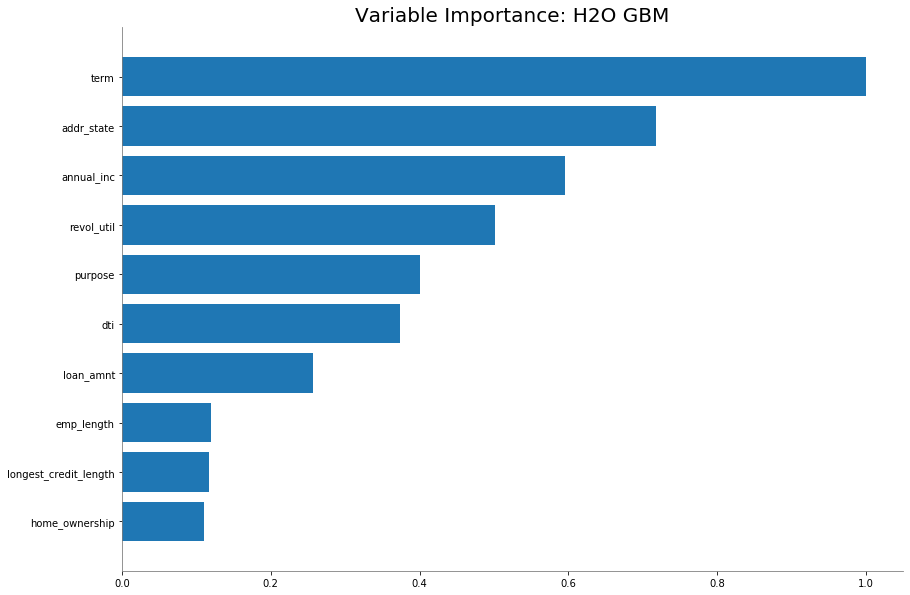

In [122]:
select_model.varimp_plot()

(Talk about issues here with address state, etc. that we may want to do feature engineering on)

Look model details, which show both train and cross-validated results,

In [123]:
select_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190808_225528


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13420850880132718
RMSE: 0.36634479496961214
LogLoss: 0.4284534363470959
Mean Per-Class Error: 0.3392781084862764
AUC: 0.7215722356421167
pr_auc: 0.3898714988854001
Gini: 0.4431444712842334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20122710239228642: 


,0,1,Error,Rate
0,97101.0,36870.0,0.2752,(36870.0/133971.0)
1,12161.0,17855.0,0.4052,(12161.0/30016.0)
Total,109262.0,54725.0,0.299,(49031.0/163987.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2012271,0.4214017,230.0
max f2,0.1325079,0.5685080,301.0
max f0point5,0.2906659,0.4046777,156.0
max accuracy,0.4309441,0.8231994,74.0
max precision,0.8423239,1.0,0.0
max recall,0.0385442,1.0,396.0
max specificity,0.8423239,1.0,0.0
max absolute_mcc,0.2346278,0.2674542,201.0
max min_per_class_accuracy,0.1831146,0.6599480,248.0
max mean_per_class_accuracy,0.1905621,0.6607219,241.0


Gains/Lift Table: Avg response rate: 18.30 %, avg score: 18.30 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.5004441,3.8276550,3.8276550,0.7006098,0.5570395,0.7006098,0.5570395,0.0382796,0.0382796,282.7654986,282.7654986
,2,0.0200016,0.4559636,3.1613965,3.4945257,0.5786585,0.4765407,0.6396341,0.5167901,0.0316165,0.0698961,216.1396503,249.4525745
,3,0.0300024,0.4271633,2.8815679,3.2902065,0.5274390,0.4408832,0.6022358,0.4914878,0.0288180,0.0987140,188.1567940,229.0206477
,4,0.0400032,0.4047802,2.5084632,3.0947707,0.4591463,0.4153363,0.5664634,0.4724499,0.0250866,0.1238006,150.8463190,209.4770655
,5,0.0500040,0.3856171,2.5184571,2.9795079,0.4609756,0.3949457,0.5453659,0.4569491,0.0251866,0.1489872,151.8457067,197.9507937
,6,0.1000018,0.3223402,2.1476130,2.5635858,0.3930967,0.3510495,0.4692359,0.4040025,0.1073761,0.2563633,114.7612996,156.3585831
,7,0.1499997,0.2822223,1.7777944,2.3016660,0.3254055,0.3010898,0.4212944,0.3696997,0.0888859,0.3452492,77.7794438,130.1666015
,8,0.2000037,0.2530308,1.5583786,2.1158328,0.2852439,0.2668617,0.3872797,0.3439886,0.0779251,0.4231743,55.8378592,111.5832828
,9,0.2999994,0.2116182,1.3236839,1.8517939,0.2422856,0.2310686,0.3389503,0.3063502,0.1323627,0.5555370,32.3683902,85.1793920
,10,0.4000012,0.1820983,1.0644128,1.6549456,0.1948290,0.1961327,0.3029194,0.2787954,0.1064432,0.6619803,6.4412830,65.4945647




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13965851880350688
RMSE: 0.3737091366337019
LogLoss: 0.4439306976625164
Mean Per-Class Error: 0.36768206533662673
AUC: 0.6829650867848847
pr_auc: 0.32254232566789165
Gini: 0.3659301735697693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19168668090668992: 


,0,1,Error,Rate
0,91190.0,42781.0,0.3193,(42781.0/133971.0)
1,12519.0,17497.0,0.4171,(12519.0/30016.0)
Total,103709.0,60278.0,0.3372,(55300.0/163987.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1916867,0.3875562,237.0
max f2,0.1116368,0.5525059,324.0
max f0point5,0.2792552,0.3510409,161.0
max accuracy,0.5584525,0.8172599,29.0
max precision,0.8041252,0.8333333,2.0
max recall,0.0349454,1.0,397.0
max specificity,0.8577401,0.9999925,0.0
max absolute_mcc,0.2117227,0.2119827,217.0
max min_per_class_accuracy,0.1786821,0.6319963,251.0
max mean_per_class_accuracy,0.1872562,0.6323179,242.0


Gains/Lift Table: Avg response rate: 18.30 %, avg score: 18.28 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100008,0.4970002,2.7416537,2.7416537,0.5018293,0.5522941,0.5018293,0.5522941,0.0274187,0.0274187,174.1653659,174.1653659
,2,0.0200016,0.4507173,2.5451074,2.6433805,0.4658537,0.4710192,0.4838415,0.5116566,0.0254531,0.0528718,154.5107406,164.3380532
,3,0.0300024,0.4230844,2.4118557,2.5662056,0.4414634,0.4363476,0.4697154,0.4865536,0.0241205,0.0769923,141.1855709,156.6205591
,4,0.0400032,0.4015286,2.2286346,2.4818129,0.4079268,0.4117185,0.4542683,0.4678449,0.0222881,0.0992804,122.8634627,148.1812850
,5,0.0500040,0.3832029,2.1020455,2.4058594,0.3847561,0.3921055,0.4403659,0.4526970,0.0210221,0.1203025,110.2045515,140.5859383
,6,0.1000018,0.3215743,1.8970693,2.1514798,0.3472375,0.3495094,0.3938045,0.4011063,0.0948494,0.2151519,89.7069252,115.1479830
,7,0.1499997,0.2819107,1.6918366,1.9982717,0.3096719,0.3005441,0.3657614,0.3675870,0.0845882,0.2997401,69.1836611,99.8271652
,8,0.2000037,0.2532015,1.4624374,1.8643049,0.2676829,0.2669469,0.3412403,0.3424254,0.0731277,0.3728678,46.2437371,86.4304913
,9,0.2999994,0.2121197,1.3216849,1.6834389,0.2419197,0.2312467,0.3081348,0.3053674,0.1321628,0.5050307,32.1684883,68.3438923
,10,0.4000012,0.1824547,1.1067228,1.5392577,0.2025733,0.1966832,0.2817440,0.2781959,0.1106743,0.6157050,10.6722824,53.9257700



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6603754,0.0096880,0.6769925,0.6694311,0.654755,0.6371619,0.6635363
auc,0.6830261,0.0016069,0.6863610,0.6827682,0.6847095,0.6801611,0.6811311
err,0.3396246,0.0096880,0.3230075,0.3305689,0.345245,0.3628381,0.3364637
err_count,11138.8,317.65182,10594.0,10842.0,11323.0,11900.0,11035.0
f0point5,0.3224245,0.0029695,0.3251890,0.3235183,0.3234241,0.3142275,0.3257639
f1,0.3880563,0.0018044,0.3871341,0.3858616,0.3919231,0.3852671,0.3900956
f2,0.4874666,0.0061627,0.4782323,0.477968,0.4972338,0.4978107,0.4860882
lift_top_group,2.7381501,0.0276118,2.7121587,2.7535036,2.7387934,2.6854308,2.8008642
logloss,0.4439307,0.0022263,0.4383353,0.4432947,0.4442467,0.4465309,0.4472460
max_per_class_error,0.4117869,0.0144380,0.4327852,0.4315755,0.3942563,0.3817971,0.4185204


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-08-08 23:13:36,20.460 sec,0.0,0.3866984,0.4759704,0.5,0.0,1.0,0.8169611
,2019-08-08 23:13:37,20.670 sec,5.0,0.3792156,0.4579520,0.6823686,0.3357337,3.2455036,0.3413441
,2019-08-08 23:13:37,20.901 sec,10.0,0.3753431,0.4490493,0.6934877,0.3507872,3.4312312,0.3380268
,2019-08-08 23:13:37,21.102 sec,15.0,0.3729609,0.4435630,0.6990067,0.3572672,3.4945257,0.3019874
,2019-08-08 23:13:37,21.324 sec,20.0,0.3714382,0.4400385,0.7025826,0.3619807,3.5811393,0.3095794
,2019-08-08 23:13:37,21.525 sec,25.0,0.3702284,0.4372671,0.7059447,0.3665956,3.6077897,0.3043473
,2019-08-08 23:13:38,21.721 sec,30.0,0.3693322,0.4351535,0.7091356,0.3706733,3.6077897,0.3056157
,2019-08-08 23:13:38,21.934 sec,35.0,0.3685210,0.4332944,0.7126032,0.3753536,3.6844094,0.2967918
,2019-08-08 23:13:38,22.154 sec,40.0,0.3678381,0.4317670,0.7150312,0.3794166,3.7410414,0.2979687
,2019-08-08 23:13:38,22.430 sec,45.0,0.3672033,0.4303547,0.7179984,0.3840169,3.7610291,0.2964869


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
term,2669.8454590,1.0,0.2270776
addr_state,1917.2905273,0.7181279,0.1630708
annual_inc,1591.6286621,0.5961501,0.1353723
revol_util,1339.4873047,0.5017097,0.1139270
purpose,1070.2753906,0.4008754,0.0910298
dti,999.2017212,0.3742545,0.0849848
loan_amnt,686.5073853,0.2571338,0.0583893
emp_length,319.0457153,0.1194997,0.0271357
longest_credit_length,314.0838928,0.1176412,0.0267137
home_ownership,293.0226746,0.1097527,0.0249224


and performance on test data

In [125]:
perf = select_model.model_performance(test_data=test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1339271564945264
RMSE: 0.36596059418266114
LogLoss: 0.4278539086966178
Mean Per-Class Error: 0.33843906329839535
AUC: 0.720091203670736
pr_auc: 0.3868482286857441
Gini: 0.44018240734147196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2105595634524753: 


,0,1,Error,Rate
0,25219.0,8249.0,0.2465,(8249.0/33468.0)
1,3294.0,4163.0,0.4417,(3294.0/7457.0)
Total,28513.0,12412.0,0.2821,(11543.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2105596,0.4190447,214.0
max f2,0.1228885,0.5653429,310.0
max f0point5,0.2911392,0.4062239,146.0
max accuracy,0.4259636,0.8238241,69.0
max precision,0.8154610,1.0,0.0
max recall,0.0414142,1.0,394.0
max specificity,0.8154610,1.0,0.0
max absolute_mcc,0.2486880,0.2648000,178.0
max min_per_class_accuracy,0.1826177,0.6603024,241.0
max mean_per_class_accuracy,0.1807694,0.6615609,243.0


Gains/Lift Table: Avg response rate: 18.22 %, avg score: 18.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.4989777,3.8283067,3.8283067,0.6975610,0.5553492,0.6975610,0.5553492,0.0383532,0.0383532,282.8306682,282.8306682
,2,0.0200122,0.4542620,3.1130724,3.4711262,0.5672372,0.4740915,0.6324786,0.5147700,0.0311117,0.0694649,211.3072406,247.1126195
,3,0.0300061,0.4243166,2.9386330,3.2937730,0.5354523,0.4387532,0.6001629,0.4894517,0.0293684,0.0988333,193.8633004,229.3773006
,4,0.04,0.4024696,2.5092437,3.0977605,0.4572127,0.4128104,0.5644472,0.4703031,0.0250771,0.1239104,150.9243706,209.7760493
,5,0.0500183,0.3838080,2.5165093,2.9813399,0.4585366,0.3929454,0.5432340,0.4548089,0.0252112,0.1491216,151.6509287,198.1339881
,6,0.1000122,0.3220714,2.1432148,2.5623797,0.3905181,0.3499451,0.4668947,0.4023898,0.1071476,0.2562693,114.3214777,156.2379714
,7,0.1500061,0.2811686,1.7998712,2.3082516,0.3279570,0.3004167,0.4205897,0.3684043,0.0899826,0.3462518,79.9871233,130.8251623
,8,0.2,0.2523318,1.5343165,2.1147915,0.2795699,0.2662726,0.3853390,0.3428745,0.0767065,0.4229583,53.4316461,111.4791471
,9,0.3000122,0.2110808,1.3033140,1.8442770,0.2374786,0.2304174,0.3360482,0.3053858,0.1303473,0.5533056,30.3314015,84.4276955
,10,0.4,0.1817686,1.0997723,1.6581735,0.2003910,0.1955007,0.3021381,0.2779178,0.1099638,0.6632694,9.9772288,65.8173528


and print out a side-by-side comparison

In [128]:
print("AUC: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(best_model.auc(train = True), best_model.auc(xval = True), perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(best_model.logloss(train = True), best_model.logloss(xval = True), perf.logloss()))

AUC: train = 0.7216, xval = 0.6830, test = 0.7201
Logloss: train = 0.4285, xval = 0.4439, test = 0.4279


(Check these values!!)

## Begin Feature Engineering

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform four feature engineering tasks on se variables:

**Creating Target Encoding** 
   - Loan Purpose
   - State of Residence

**Separating Typical from Extreme**
   - Loan Amount
   - Annual Income
   - Debt to Income Ratio
   - Number of Delinquencies in the Past 2 Years
   - Revolving Credit Line Utilized
   - Number of Credit Lines
   - Longest Credit Length

**Create Indicator Functions**
   - Term
   - Income Verification Status
   - Employment Length (Missing Value)

**Combining Categories** 
   - Home Ownership

In [129]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

## 1. Creating Target Encoding

### Cross Validation with Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [131]:
cv_nfolds = 5
cv_seed = 1234
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [132]:
train["cv_fold"].table()

cv_fold,Count
0,32823
1,32804
2,33044
3,32570
4,32746


In [133]:
import numpy as np
import pandas as pd

In [134]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [135]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [136]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### 1.1. Target Encoding for Loan Purpose

### Creating Target Encoding for Loan Purpose

Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting of the later group.

In [45]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  93261    56.87
1          credit_card  30792    18.78
2                other  10492     6.40
3     home_improvement   9872     6.02
4       major_purchase   4686     2.86
5       small_business   3841     2.34
6                  car   2842     1.73
7              medical   2029     1.24
8              wedding   1751     1.07
9               moving   1464     0.89
10               house   1245     0.76
11            vacation   1096     0.67
12         educational    418     0.25
13    renewable_energy    198     0.12


In [46]:
df = mean_target(train, "purpose")

In [47]:
df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,purpose,nrow,mean_bad_loan
0,small_business,3841,0.309034
1,renewable_energy,198,0.227273
2,other,10492,0.214354
3,educational,418,0.210526
4,moving,1464,0.207650
5,medical,2029,0.203056
6,debt_consolidation,93261,0.189479
7,house,1245,0.182329
8,vacation,1096,0.178832
9,credit_card,30792,0.157281


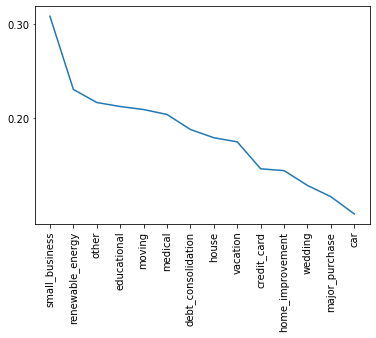

In [48]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [49]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [50]:
train = train.merge(te_purpose, all_x = True)

In [51]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

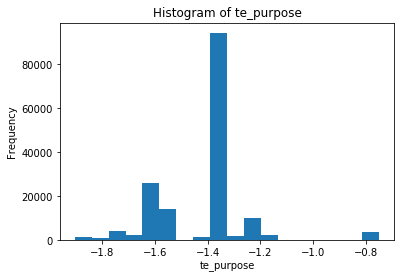

In [52]:
train["te_purpose"].hist()

### 1.2. Target Encoding for State of Residence

We will also use a mean target encoding for state of residence for a reason similar to that for purpose.

In [53]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:5])

  addr_state  Count  Percent
0         CA  28702    17.50
1         NY  14285     8.71
2         TX  12128     7.40
3         FL  11396     6.95
4         NJ   6457     3.94


In [54]:
df = mean_target(train, "addr_state")

In [55]:
df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
print(df[0:5])

  addr_state  nrow  mean_bad_loan
0         NE    13       0.538462
1         TN  1327       0.238885
2         NV  2387       0.227901
3         MS   163       0.226994
4         IN  1463       0.217362


In [56]:
print(df[45:50])

   addr_state  nrow  mean_bad_loan
45         WV   714       0.131653
46         DC   584       0.114726
47         ID     9       0.111111
48         WY   376       0.109043
49         ME     3       0.000000


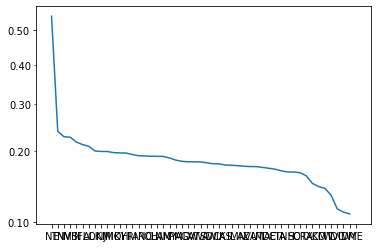

In [57]:
plt.yscale("logit")
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [58]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

In [60]:
df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

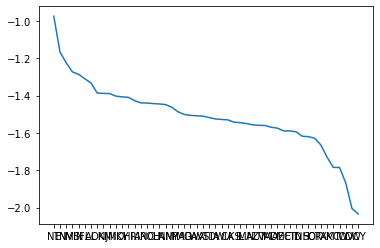

In [61]:
plt.plot(df["addr_state"], df["mean_te_addr_state"])

In [62]:
train = train.merge(te_addr_state, all_x = True)

In [63]:
x_trans.remove("addr_state")
x_trans.append("te_addr_state")

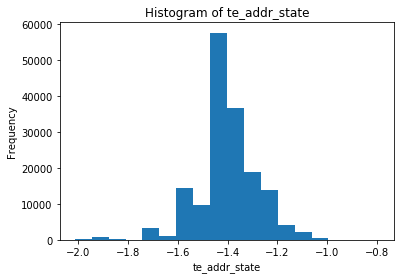

In [64]:
train["te_addr_state"].hist()

## 2. Separating Typical from Extreme

### 2.1. Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \$5,000 and above \$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
loan\_amnt\_core & = & \max(5000, \min(loan\_amnt, 30000)) \\
loan\_amnt\_diff & = & loan\_amnt - loan\_amnt\_core
\end{eqnarray}

In [20]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11325
0.75,18000
0.95,30000
1,35000


In [21]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

In [22]:
df = mean_target(train, "loan_amnt_cat")

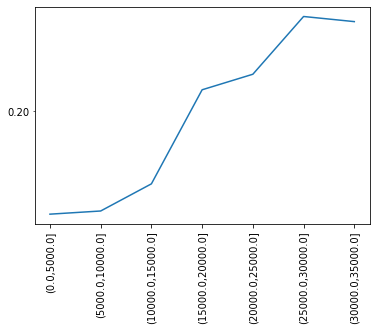

In [23]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [24]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",25785,0.163234
1,"(5000.0,10000.0]",50384,0.164278
2,"(10000.0,15000.0]",35552,0.173436
3,"(15000.0,20000.0]",24659,0.208281
4,"(20000.0,25000.0]",14447,0.214508
5,"(25000.0,30000.0]",6913,0.238825
6,"(30000.0,35000.0]",6247,0.236594


In [25]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### 2.2. Separating Typical from Extreme Annual Income

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \$10,000 to \$105,000 and is relatively flat above \$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
annual\_inc\_core & = & \max(10000, \min(annual\_inc, 105000)) \\
annual\_inc\_diff & = & annual\_inc - annual\_inc\_core
\end{eqnarray}

In [40]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,1896
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,145000
1,7.14178e+06


In [41]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

In [42]:
df = mean_target(train, "annual_inc_cat")

IndexError: tuple index out of range

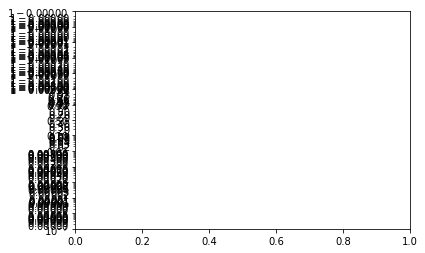

In [43]:
plt.yscale("logit")
plt.plot(df["annual_inc_cat"].index, df["mean_bad_loan"])

In [ ]:
df[0:6]

In [ ]:
df[20:31]

In [44]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### 2.3. Debt to Income Ratio

### Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
dti\_core & = & \max(5, \min(dti, 30)) \\
dti\_diff & = & dti - dti\_core
\end{eqnarray}

In [65]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.79
0.25,10.23
0.5,15.62
0.75,21.26
0.95,29.02
1,39.99


In [66]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

In [67]:
df = mean_target(train, "dti_cat")

IndexError: tuple index out of range

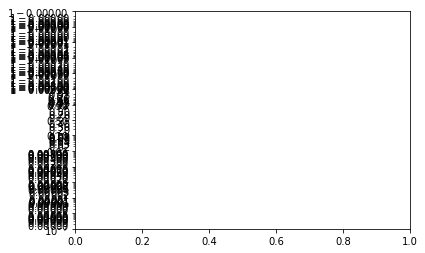

In [68]:
plt.yscale("logit")
plt.plot(df["dti_cat"].index, df["mean_bad_loan"])

In [ ]:
df[30:41]

In [ ]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### 2.4. Number of Delinquencies in the Past 2 Years

### Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
delinq\_2yrs\_core & = & \min(delinq\_2yrs, 3) \\
delinq\_2yrs\_diff & = & delinq\_2yrs - delinq\_2yrs\_core
\end{eqnarray}

In [69]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,29


In [70]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

In [71]:
mean_target(train, "delinq_2yrs_cat")

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.181037
1,"(0.0,1.0]",17158,0.189299
2,"(1.0,2.0]",4635,0.201510
3,"(2.0,3.0]",1488,0.221774
4,"(3.0,4.0]",579,0.215889
5,"(4.0,5.0]",310,0.216129


In [72]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)

train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### 2.5. Revolving Credit Line Utilized

### Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
revol\_util\_0 & = & I(revol\_util == 0) \\
revol\_util\_core & = & \max(5, \min(revol\_util, 30)) \\
revol\_util\_diff & = & revol\_util - revol\_util\_core
\end{eqnarray}

In [73]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.7
0.25,35.6
0.5,55.8
0.75,74.2
0.95,92.5
1,150.7


In [74]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

In [75]:
df = mean_target(train, "revol_util_cat")

IndexError: tuple index out of range

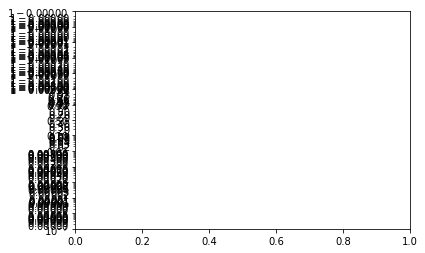

In [76]:
plt.yscale("logit")
plt.plot(df["revol_util_cat"].index, df["mean_bad_loan"])

In [ ]:
df[20:25]

In [77]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0

train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)

train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### 2.6. Number of Credit Lines

### Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
total\_acc\_core & = & \min(total\_acc, 50) \\
total\_acc\_diff & = & total\_acc - total\_acc\_core
\end{eqnarray}

In [78]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,118


In [79]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

In [80]:
df = mean_target(train, "total_acc_cat")

IndexError: tuple index out of range

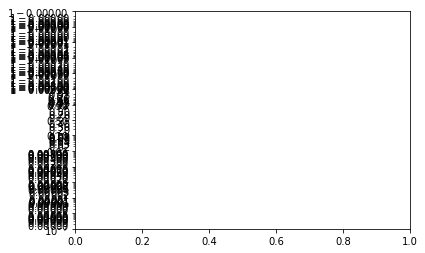

In [81]:
plt.yscale("logit")
plt.plot(df["total_acc_cat"].index, df["mean_bad_loan"])

In [82]:
(train["total_acc"] == None).table()

C1,Count
0,163958
1,29


In [83]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.153788
1,"(0.0,5.0]",2309,0.226072
2,"(5.0,10.0]",12717,0.210034


In [84]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",11251,0.163719
9,"(40.0,45.0]",7174,0.161137
10,"(45.0,50.0]",4203,0.157507
11,"(50.0,55.0]",2350,0.140426
12,"(55.0,60.0]",1287,0.165501


In [85]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)

train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### 2.7. Longest Credit Length

### Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
longest\_credit\_length\_core & = & \max(3, \min(longest\_credit\_length, 20)) \\
longest\_credit\_length\_diff & = & longest\_credit\_length - longest\_credit\_length\_core
\end{eqnarray}

In [86]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [87]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

In [88]:
df = mean_target(train, "longest_credit_length_cat")

IndexError: tuple index out of range

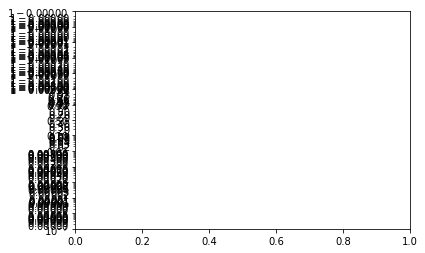

In [89]:
plt.yscale("logit")
plt.plot(df["longest_credit_length_cat"].index, df["mean_bad_loan"])

In [ ]:
df[0:4]

In [ ]:
df[20:26]

In [90]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)

train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

----
# ^^^^ EVERYTHING ABOVE THIS ^^^^
-----

## 3. Create Indicator Functions

### 3.1. Term

### Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [26]:
train["term"].table()

term,Count
36 months,129950
60 months,34037


In [27]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

In [28]:
train["term_60months"].table()

term_60months,Count
0,129950
1,34037


### 3.2. Income Verification Status

### Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [91]:
train["verification_status"].table()

verification_status,Count
not verified,59155
verified,104832


In [92]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"

In [93]:
train["verified"].table()

verified,Count
0,59155
1,104832


### 3.3. Employment Length (Missing Value)

### Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [29]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.68435293299533
maxs,10.0
sigma,3.6106637311002365
zeros,14248
missing,5804
0,10.0
1,0.0
2,10.0


In [30]:
x_trans.append("emp_length_missing")

train["emp_length_missing"] = train["emp_length"] == None

In [31]:
mean_target_encoding(train, "emp_length_missing")

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52145
1,0,-1.03907
0,1,-1.51691
1,1,-1.02443
0,2,-1.51666
1,2,-1.05314
0,3,-1.51154
1,3,-1.02223
0,4,-1.51157
1,4,-1.01582


In [32]:
df = mean_target(train, "emp_length")

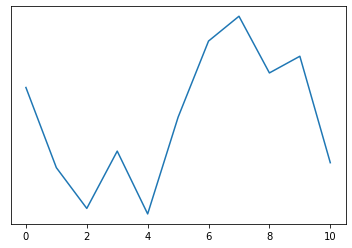

In [33]:
plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [34]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.262922
1,0.0,14248,0.184307
2,1.0,11414,0.177238
3,2.0,15766,0.173728
4,3.0,13611,0.178679
5,4.0,11024,0.173258
6,5.0,12347,0.181664
7,6.0,10000,0.188500
8,7.0,9079,0.190770
9,8.0,7424,0.185614


## 4. Combining Categories
### 4.1.  Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [35]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,ANY,1,0.000000
1,MORTGAGE,79714,0.164137
2,NONE,30,0.233333
3,OTHER,156,0.224359
4,OWN,13560,0.188348
5,RENT,70526,0.203273


In [36]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()

In [37]:
train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
ANY,OTHER,1
MORTGAGE,MORTGAGE,79714
NONE,OTHER,30
OTHER,OTHER,156
OWN,OWN,13560
RENT,OTHER,70526


In [38]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,79714,0.164137
1,OTHER,70713,0.203329
2,OWN,13560,0.188348


In [39]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

## Train Models Using Transformed Data

In [94]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190808_225528,0.685467,0.44476,0.365936,0.373917,0.139814
StackedEnsemble_BestOfFamily_AutoML_20190808_225528,0.685411,0.444813,0.365647,0.373942,0.139833
GBM_1_AutoML_20190808_225528,0.682965,0.443931,0.368204,0.373709,0.139659
XGBoost_1_AutoML_20190808_225528,0.681806,0.444222,0.367795,0.373883,0.139789
XGBoost_3_AutoML_20190808_225528,0.678912,0.446005,0.370638,0.374385,0.140164
XGBoost_2_AutoML_20190808_225528,0.67563,0.446593,0.373523,0.374935,0.140576
GLM_grid_1_AutoML_20190808_225528_model_1,0.674163,0.447619,0.373453,0.374973,0.140605
DRF_1_AutoML_20190808_225528,0.662111,0.452901,0.382917,0.377223,0.142298


In [95]:
print(x_trans)

['emp_length', 'dti', 'loan_amnt_core', 'loan_amnt_delta', 'term_60months', 'emp_length_missing', 'home_ownership_3cat', 'annual_inc_core', 'annual_inc_delta', 'te_purpose', 'te_addr_state', 'delinq_2yrs_core', 'delinq_2yrs_delta', 'revol_util_0', 'revol_util_core', 'revol_util_delta', 'total_acc_core', 'total_acc_delta', 'longest_credit_length_core', 'longest_credit_length_delta', 'verified']


In [96]:
aml_trans = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml_trans.train(x = x_trans, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [97]:
print(aml_trans.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190808_231850,0.684324,0.445088,0.367538,0.374065,0.139924
StackedEnsemble_BestOfFamily_AutoML_20190808_231850,0.683558,0.445267,0.366618,0.374121,0.139966
GBM_1_AutoML_20190808_231850,0.683094,0.44387,0.367727,0.373689,0.139643
XGBoost_3_AutoML_20190808_231850,0.681633,0.445192,0.368241,0.374037,0.139903
XGBoost_1_AutoML_20190808_231850,0.680815,0.444765,0.368709,0.374216,0.140037
GLM_grid_1_AutoML_20190808_231850_model_1,0.677065,0.445743,0.372784,0.374449,0.140212
XGBoost_2_AutoML_20190808_231850,0.675872,0.446644,0.372443,0.374995,0.140621
DRF_1_AutoML_20190808_231850,0.663243,0.452088,0.38258,0.377242,0.142312


In [98]:
best_model_trans = h2o.get_model(aml_trans.leaderboard[2,'model_id'])

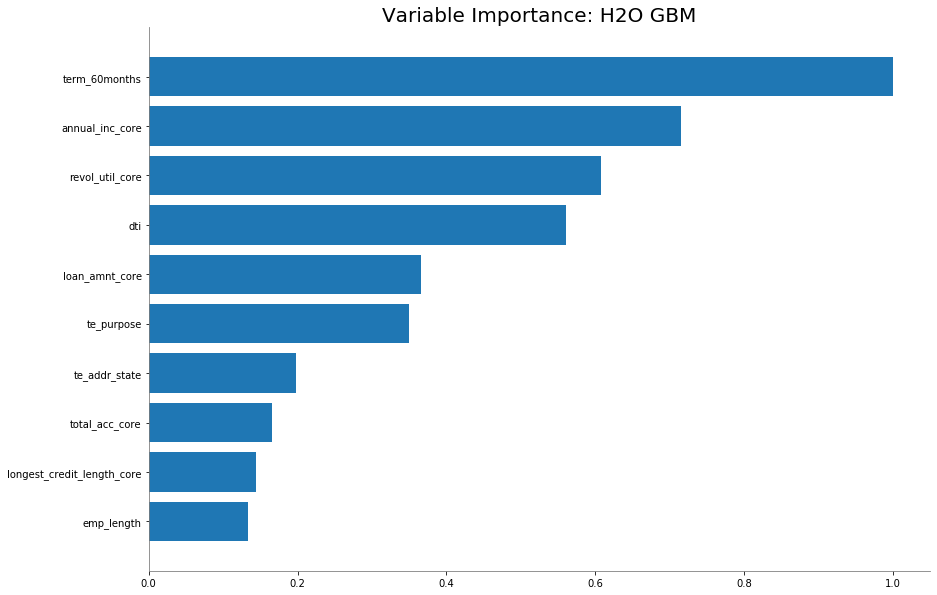

In [99]:
best_model_trans.varimp_plot()

In [100]:
print("AUC (orig): train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(best_model.auc(train = True),
              best_model.auc(valid = True),
              best_model.auc(xval = True)))

TypeError: unsupported format string passed to NoneType.__format__

In [101]:
print("AUC (trans): train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.auc(train = True),
              best_model_trans.auc(valid = True),
              best_model_trans.auc(xval = True)))

TypeError: unsupported format string passed to NoneType.__format__

In [102]:
print("Logloss (orig): train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(best_model.logloss(train = True),
              best_model.logloss(valid = True),
              best_model.logloss(xval = True)))

TypeError: unsupported format string passed to NoneType.__format__

In [103]:
print("Logloss (trans): train = {:.4f}, valid = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.logloss(train = True),
              best_model_trans.logloss(valid = True),
              best_model_trans.logloss(xval = True)))

TypeError: unsupported format string passed to NoneType.__format__

## Shutdown H2O Cluster

In [ ]:
h2o.cluster().shutdown()